# Your Name: _________

# Homework 3
## Model Selection and Tuning

This exercise should guide you through performing a predictive modeling analysis.  You will choose a model type, set critical complexity parameters, and apply it to select prospects for a direct mailing charity campaign.  If you get stuck, please ask questions on the discussion forum – it’s likely that other students are running into the same issues!!

Mailing marketing offers can be costly.  We want to send out solicitations for donations; each solicitation costs us a small amount.  Under NYU Classes->Resources->Data->Homework 3 Mailing you will find two data files from our problem.  The files are mailing_test.arff and mailing_train.arff. 

You can also find these two files in this repository's "data" folder.

You will analyze (at least) three algorithms for these data: tree induction, logistic regression, and any other method of your choice.  Your ultimate goal is to build the ‘best’ model given the data and to do some analytics on the model.  You have a budget of $3000, and you will decide how to spend that on targeting. 

In this data set if `TARGET_B = 1` the person donated, otherwise, they did not donate.

### Loading Data
Load and/or install the following packages:
- `liac-arff`

In [1]:
# for example
! sudo pip install liac-arff

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import arff

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Load mailing_train.arff.
(see documentation [here](https://pypi.python.org/pypi/liac-arff))

In [3]:
mailing_data_train = arff.load(open('data/mailing_train.arff'))
mailing_data_test = arff.load(open('data/mailing_test.arff'))

Load the data into a pandas dataframe and use "head" to look at the data.

In [4]:
train_df = pd.DataFrame(mailing_data_train['data'])
test_df = pd.DataFrame(mailing_data_test['data'])
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,AL,T2,NaN,H,NaN,5,F,None,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,,X,12.0,6.0,0
1,CA,,79.0,,NaN,None,F,None,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,,X,28.0,20.0,0
2,FL,S1,86.0,H,NaN,7,M,9,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,,X,14.0,37.0,0
3,MO,T2,25.0,U,NaN,1,M,4,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,,,7.0,6.0,0
4,CA,U2,69.0,U,NaN,3,F,3,5.0,0.0,...,2.0,0.0,0.0,0.0,0.0,,X,22.0,11.0,0


In [5]:
# give the columns their proper names
a = mailing_data_train['attributes']
train_df.columns = [i[0] for i in a] 
test_df.columns = [i[0] for i in a] 
train_df.head()

,STATE,DOMAIN,AGE,HOMEOWNR,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,...,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,MAJOR,PEPSTRFL,NUMPRM12,NGIFTALL,TARGET_B
0,AL,T2,NaN,H,NaN,5,F,None,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,,X,12.0,6.0,0
1,CA,,79.0,,NaN,None,F,None,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,,X,28.0,20.0,0
2,FL,S1,86.0,H,NaN,7,M,9,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,,X,14.0,37.0,0
3,MO,T2,25.0,U,NaN,1,M,4,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,,,7.0,6.0,0
4,CA,U2,69.0,U,NaN,3,F,3,5.0,0.0,...,2.0,0.0,0.0,0.0,0.0,,X,22.0,11.0,0


### Missing Values
There seem to be many missing values (NaN). We will use the built-in feature [.dropna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) in Pandas to drop any rows with missing values. Dropping NA's is not necessarily the best thing to do in practice, but that is a topic for another day.

In [6]:
train_df_no_nas = train_df.dropna()
test_df_no_nas = test_df.dropna()

print("original number of rows: \t" + str(train_df.shape[0]))
print("New number of rows: \t \t" + str(train_df_no_nas.shape[0]))

original number of rows: 	18160
New number of rows: 	 	1295


That seems to throw away a lot of data, let's drop columns with Na's instead.

In [7]:
train_df_no_nas = train_df.dropna(axis=1)

# make sure the test data has the same columns
test_df_no_nas = test_df[np.array(train_df_no_nas.columns)]

print("original number of cols: \t" + str(train_df.shape[1]))
print("New number of cols: \t \t" + str(train_df_no_nas.shape[1]))

original number of cols: 	28
New number of cols: 	 	10


Since you have a fixed budget, you’ll be ranking the instances based on their predicted probability of donation.  This will maximize the expected number of donations for the $3000 budget.  Therefore, be sure to compare the “ROC Area” measure that we discussed in class.

SK Learn's algorithms cannot easily handle categorical data, so convert each categorical feature into a series of binary "dummy" variables

In [8]:
X = train_df_no_nas.loc[:, train_df_no_nas.columns != 'TARGET_B']
Y = train_df_no_nas["TARGET_B"]
X = pd.get_dummies(X)
X.head()

,HIT,NUMPRM12,NGIFTALL,STATE_AA,STATE_AE,STATE_AK,STATE_AL,STATE_AP,STATE_AR,STATE_AZ,...,GENDER_,GENDER_C,GENDER_F,GENDER_J,GENDER_M,GENDER_U,MAJOR_,MAJOR_X,PEPSTRFL_,PEPSTRFL_X
0,0.0,12.0,6.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,0.0,28.0,20.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,1.0,14.0,37.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,0.0,7.0,6.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,5.0,22.0,11.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


## Tuning Models
Build the best model you can by changing the complexity paraemters for each of the following three model types, in terms of their generalization performance using ROC Area (you can use a 66% train/test split for this to save time):

### Trees
Look at the documentation for decision tree classifies [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and decide which complexity parameter to tune - min_samples_split, or min_samples_leaf.

Display a table showing the AUC over a range of your chosen complexity parameter.

I have done it for max_depth already. **Choose a different complexity parameter to use to find the best validation performance of the tree.**

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score # for AUC scores


# for example, using max_depth
complexity_param = "max_depth"

# create an empty list to hold the cross validation scores
accuracies_cross_validation = []

# Model
#number of folds for cross validation
n_folds = 3

param_range = range(1,10)
for param in param_range:
    model_Tree = DecisionTreeClassifier(max_depth = param) ### BE SURE TO CHANGE THIS!
    AUC = np.mean(cross_val_score(model_Tree, X, Y,cv=n_folds))
    accuracies_cross_validation.append(AUC)
    #print(complexity_param + " = " + str(param) + ", AUC = " + str(AUC))

Provide Charts and graphs to support your choice of complexity parameter

In [10]:
# Creates a dictionary with curly brackest {}
d = {complexity_param :[i for i in param_range], "AUC" : accuracies_cross_validation} 
# Convert the dict into a data frame
df = pd.DataFrame(d, columns =[complexity_param,'AUC'] )
df

,max_depth,AUC
0,1,0.799119
1,2,0.800330
2,3,0.799835
3,4,0.799670
4,5,0.799009
5,6,0.796806
6,7,0.797357
7,8,0.795264
8,9,0.790584


In [11]:
# Best Model
df.loc[(df.iloc[:,1] == max(df.iloc[:,1]))]

,max_depth,AUC
1,2,0.80033


Text(0.5,1,'Decision Tree Classifier\n AUC vs. max_depth')

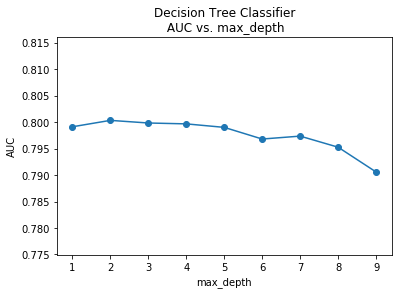

In [12]:
%matplotlib inline
#df.plot.line(df.columns[0],df.columns[1])

plt.scatter(df.iloc[:,0],df.iloc[:,1])
plt.plot(df.iloc[:,0],df.iloc[:,1])
plt.xlabel(complexity_param)
plt.ylabel('AUC')
plt.title("Decision Tree Classifier\n AUC vs. "+ complexity_param)

I choose the model with the following complexity:

In [13]:
# your answer here!

### Logistic Regression
Look at the documentation for logistic regression classifiers [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Display a table showing the AUC over a range of your chosen penalty parameter (`"l1`" or `"l2"`). Change the argument "C" by exponential values of 10 to find the best cross-validated AUC.

In [14]:
# your code here!

### Your Choice!
A third model type of your choice.  Some model types won’t have a complexity parameter to tune, so just run them with the default settings.  Some suggestions: [Naïve Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) (see Chapter 9; no complexity parameter), [kNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) – see Chapter 6. increase parameter `n_neighbors` to make a simpler model.

In [15]:
# your code here!

### Which Model to Choose
Tell us the process you went through to set the complexity parameter for each model, ideally providing appropriate charts or graphs to support your decision (note: you don’t need to give us the full fitting curves, but do provide convincing evidence as to why you chose the parameter setting you did). 
#### Your answer here!
...

Now, pick one model to move forward with.  Why did you select this one?
#### Your answer here!
...

## Which People to Target
I have provided the code below for you to merge the train and the test sets to ensure they both have the same column types.

In [16]:
from sklearn.model_selection import train_test_split
# First, let us make sure that the test set and training set have the same columns
both= pd.concat([train_df_no_nas,test_df_no_nas],axis=0)
both.dropna(axis=1)
X = both.iloc[:,both.columns != 'TARGET_B']

# remember to get the dummy variables
X = pd.get_dummies(X)

# the target is entered as a string, let's convert it to numeric
Y = pd.to_numeric(both['TARGET_B'])

train_size = train_df_no_nas.shape[0] # the number of rows in the training set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size,shuffle=False) # turn shuffle off

Apply your selected model to the test data. Store predictions as probability scores of being class `1` using `predict_proba`.

In [26]:
## As a demonstration I test it on a basic out-of-the-box logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,Y_train)
probabilities = model.predict_proba(X_test)

# Do it with your model here!

Use the estimated probabilities to rank the prospects for propensity to donate if targeted with a mailing. Hint: use [DataFrame.sort_values()](http://pandas.pydata.org/pandas-docs/version/0.18/generated/pandas.DataFrame.sort.html). Print the top 10 rows of the data frame.

In [27]:
d = {'predicted_prob_donate' : probabilities[:,1], # we only select the probability of class = 1 (i.e. the second column)
     'actually_donated' : Y_test}
df = pd.DataFrame(d)
df_sorted = df.sort_values("predicted_prob_donate",ascending=False)

# your work here. print the top 10 rows.

### How many people can you target?
The cost of each mailing is \$2 and the budget is $3000?

In [28]:
# You work here!

[your answer here]

### What is the Lift?
Compute the lift you would (expect to) achieve if you target the top 1%, 5%, and 10% of the people in the test set by your ranking. What percent of the entire population would donate (if chosen at random)?  How do these compare?

In [29]:
# You work here!

[your answer here]

Here is the code used to construct a lift curve (lift vs. percent targeted).

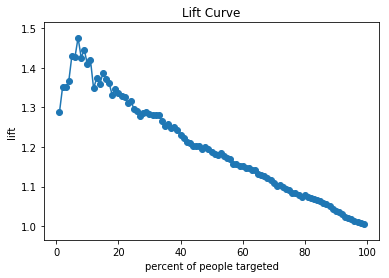

In [30]:
lift = {'pct' : [], 'lift' : []}
for i in range(1,100):
    top_n_pct = float(i)/100 # percent
    top_n_rows = int(df_sorted.shape[0]*top_n_pct)

    # number of "true positives" in the top n%
    TP = sum(pd.to_numeric(df_sorted.iloc[1:top_n_rows,0]))
    pct_TP = np.mean(pd.to_numeric(df_sorted.iloc[1:top_n_rows,0]))

    # base rate
    base_rate = np.mean(pd.to_numeric(df["actually_donated"]))

    # lift
    lift['lift'].append(pct_TP / base_rate)
    lift['pct'].append(i)
    
lift_df = pd.DataFrame(lift)

plt.scatter(lift_df['pct'],lift_df['lift'])
plt.plot(lift_df['pct'],lift_df['lift'])
plt.xlabel('percent of people targeted')
plt.ylabel('lift')
plt.title('Lift Curve')
plt.show()

## Cost-Benefit Analysis
Assume that each donation is \$10 and the cost of each mailer is \$2.

Compute the (expected) profit for each of the three thresholds (1%, 5%, 10%) of the population.  

In [31]:
# You work here!

Construct a cumulative profit curve (profit vs. percent targeted) and show it below.

In [32]:
# Your work here!

### Maximizing Profit
What percent of the people would you target if you are trying to maximize your total expected profit?  What would the total profit be?

[your answer here]

### Breaking Even
What percent of the people would you target if you want to send the most mailings you can and still “break even”?  

[your answer here]

### Thinking about the budget
What is your expected profit for your $3000 budget?  Does this budget make business sense for these data?  Make a recommendation for what to do.

[your answer here]

## Turning in Assignment
Save this notebook as a pdf using

`File>Download as>PDF via LaTeX (.pdf)` 

submit on NYU classes